In [1484]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer

print("OK ✅", pd.__version__, sklearn.__version__)

OK ✅ 3.0.0 1.8.0


# Laboratorio 1 — AlpesHearth

## 1. Carga de datos

In [1485]:

TRAIN_PATH = "Datos Lab 1.csv"
TEST_PATH  = "Datos Test Lab 1.csv"       
TARGET_COL = "CVD Risk Score"    

df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH, sep=";")
data_copy = df.copy()
data_test_copy = df_test.copy()

## 2. Exploración y perfilamiento

### Unicidad 
los datos, revisaremos que no existan datos duplicados, que harian que nuestro modelo empiece a tomar tendencias que no deberia, todos estos registros duplicados los limpiearemos.

In [1486]:
data_copy["_idx"] = data_copy.index

def choose_row(group):
    positives = group[group["CVD Risk Score"] >= 0]

    if not positives.empty:

        return positives.loc[positives["_idx"].idxmax()]
    else:

        return group.loc[group["_idx"].idxmax()]

unique_df = data_copy.groupby("Patient ID", group_keys=False).apply(choose_row)

duplicados = data_copy[~data_copy["_idx"].isin(unique_df["_idx"])]

duplicados = duplicados.assign(
    repeticiones=duplicados.groupby("Patient ID")["Patient ID"].transform("size")
).sort_values(["repeticiones", "Patient ID"], ascending=[False, True])

duplicados

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level,_idx,repeticiones
17,AhYt1346,09-28-2020,M,41.0,71.300,1.730,23.800,107.9,139/61,253.0,...,173.000,NaN,139.0,NaN,Hypertension Stage 1,146.0,16.770,HIGH,17,2
1227,AhYt1346,09-28-2020,M,41.0,71.300,1.730,23.800,107.9,139/61,253.0,...,173.000,NaN,139.0,NaN,Hypertension Stage 1,146.0,-13.090,HIGH,1227,2
130,BQvQ6431,09/11/2020,M,33.0,118.300,1.690,41.400,72.1,116/93,171.0,...,210.554,0.427,116.0,93.0,Hypertension Stage 2,97.0,17.500,LOW,130,2
1469,BQvQ6431,09/11/2020,M,33.0,118.300,1.690,41.400,72.1,116/93,171.0,...,210.554,0.427,116.0,93.0,Hypertension Stage 2,97.0,29.833,LOW,1469,2
850,CDsa2651,23/06/2025,M,39.0,73.300,1.740,24.200,95.0,111/84,158.0,...,174.000,0.546,111.0,84.0,Hypertension Stage 1,91.0,26.604,INTERMEDIARY,850,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,yAIB3468,29 Jan 22,F,53.0,70.300,1.670,6.235,88.8,130/97,277.0,...,167.000,0.532,130.0,97.0,Hypertension Stage 1,187.0,17.080,HIGH,469,1
512,yAsk5000,01-09-2023,F,59.0,89.400,1.670,32.100,107.2,118/89,206.0,...,167.000,0.642,118.0,89.0,Hypertension Stage 1,122.0,18.440,HIGH,512,1
547,yvsn3005,28 Oct 20,F,60.0,54.300,1.810,16.600,99.1,133/65,187.0,...,181.000,0.548,133.0,65.0,Hypertension Stage 1,79.0,15.710,INTERMEDIARY,547,1
95,zcgB3048,12/06/2020,M,38.0,60.436,1.506,20.269,79.7,168/63,119.0,...,150.616,0.529,168.0,63.0,Hypertension Stage 2,43.0,14.834,HIGH,95,1


In [1487]:
def seleccionar_registro_unico(df):
    df = df.copy()

    # Crear columna temporal para convertir fecha SIN modificar la original
    df["_temp_date"] = pd.to_datetime(
        df["Date of Service"],
        format="mixed",
        errors="coerce"
    )

    # Crear índice auxiliar si no existe
    if "_idx" not in df.columns:
        df["_idx"] = df.index

    # Ordenar usando la columna temporal
    df = df.sort_values(
        ["Patient ID", "_temp_date", "_idx"],
        ascending=[True, False, False]
    )

    # Seleccionar el registro más reciente por paciente
    unique_df = df.groupby("Patient ID", group_keys=False).head(1)

    # Quitar columnas temporales
    unique_df = unique_df.drop(columns=["_temp_date", "_idx"], errors="ignore")

    unique_df = unique_df.reset_index(drop=True)

    return unique_df


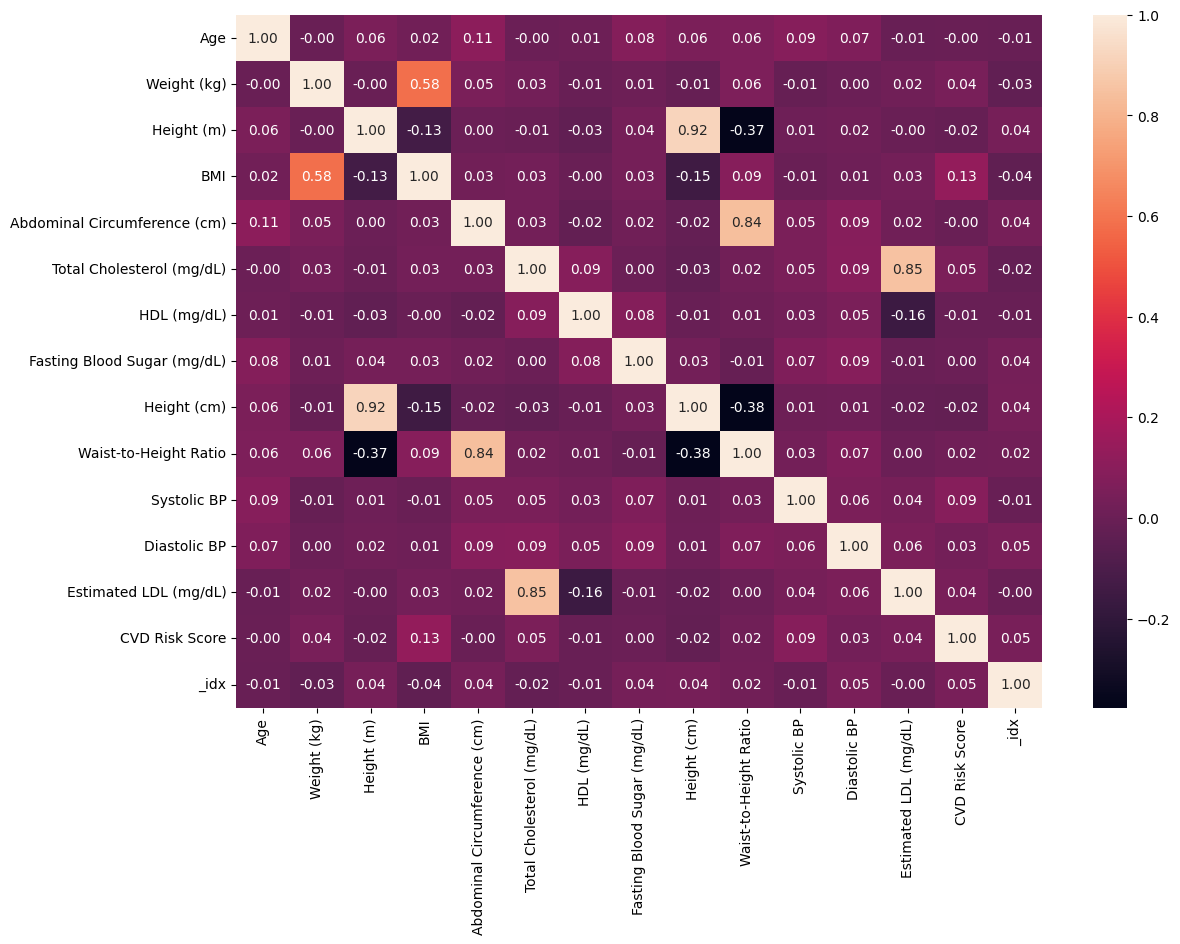

In [1488]:
plt.figure(figsize=(13, 9))  # ancho x alto en pulgadas
sns.heatmap(data_copy.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()


Vemos que aun tenemos muchos valores en NULL, esto nos afecta porque nuestro modelo no podra estar bien ajustado y tendremos que corregir estos datos. 

In [1489]:
def limpieza_variables_completitud(df):
    df = df.copy()

    df["Height (cm)"] = df["Height (cm)"].fillna(df["Height (m)"] * 100)
    df = df[~(df["Height (cm)"].isna() & df["Height (m)"].isna())]

    df["height_m_temp"] = df["Height (cm)"] / 100

    df["BMI"] = df["BMI"].fillna(df["Weight (kg)"] / (df["height_m_temp"] ** 2))
    df = df[~df["BMI"].isna()]

    df["Waist-to-Height Ratio"] = df["Waist-to-Height Ratio"].fillna(
        df["Abdominal Circumference (cm)"] / df["Height (cm)"]
    )
    df = df[~df["Waist-to-Height Ratio"].isna()]

    df = df.drop(columns=["height_m_temp"], errors="ignore")

    def split_bp(value):
        if isinstance(value, str) and "/" in value:
            sys, dia = value.split("/")
            return float(sys), float(dia)
        return (None, None)

    df[["BP_sys", "BP_dia"]] = df["Blood Pressure (mmHg)"].apply(
        lambda x: pd.Series(split_bp(x))
    )

    df["Systolic BP"] = df["Systolic BP"].fillna(df["BP_sys"])
    df["Diastolic BP"] = df["Diastolic BP"].fillna(df["BP_dia"])

    df = df.drop(columns=["BP_sys", "BP_dia"])

    df["Weight (kg)"] = df["Weight (kg)"].fillna(
        df["BMI"] * (df["Height (cm)"] / 100) ** 2
    )
    df["Weight (kg)"] = df["Weight (kg)"].fillna(df["Weight (kg)"].median())

    df["HDL (mg/dL)"] = df["HDL (mg/dL)"].fillna(df["HDL (mg/dL)"].median())
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Total Cholesterol (mg/dL)"] = df["Total Cholesterol (mg/dL)"].fillna(
        df["Total Cholesterol (mg/dL)"].median()
    )
    df["Abdominal Circumference (cm)"] = df["Abdominal Circumference (cm)"].fillna(
        df["Waist-to-Height Ratio"] * df["Height (cm)"]
    )
    df["Abdominal Circumference (cm)"] = df["Abdominal Circumference (cm)"].fillna(
        df["Abdominal Circumference (cm)"].median()
    )
    df["Fasting Blood Sugar (mg/dL)"] = df["Fasting Blood Sugar (mg/dL)"].fillna(
        df["Fasting Blood Sugar (mg/dL)"].median()
    )
    df["Estimated LDL (mg/dL)"] = df["Estimated LDL (mg/dL)"].fillna(
        df["Estimated LDL (mg/dL)"].median()
    )

    return df

data_copy = limpieza_variables_completitud(data_copy)

((data_copy.isnull().sum()/data_copy.shape[0])).sort_values(ascending=False)


Height (m)                      0.035496
CVD Risk Score                  0.017748
Patient ID                      0.000000
Age                             0.000000
Date of Service                 0.000000
Weight (kg)                     0.000000
BMI                             0.000000
Abdominal Circumference (cm)    0.000000
Sex                             0.000000
Blood Pressure (mmHg)           0.000000
Total Cholesterol (mg/dL)       0.000000
Fasting Blood Sugar (mg/dL)     0.000000
HDL (mg/dL)                     0.000000
Diabetes Status                 0.000000
Physical Activity Level         0.000000
Family History of CVD           0.000000
Smoking Status                  0.000000
Height (cm)                     0.000000
Waist-to-Height Ratio           0.000000
Diastolic BP                    0.000000
Systolic BP                     0.000000
Blood Pressure Category         0.000000
Estimated LDL (mg/dL)           0.000000
CVD Risk Level                  0.000000
_idx            

### Consistencia
Miramos que todos los datos que tenemos, vengan con el formato que se nos indica

Primero vemos los valores que no son numericos

In [1490]:
print(data_copy["Sex"].value_counts(dropna=False))
print(" ")
print(data_copy["Smoking Status"].value_counts(dropna=False))
print(" ")
print(data_copy["Diabetes Status"].value_counts(dropna=False))
print(" ")
print(data_copy["Physical Activity Level"].value_counts(dropna=False))
print(" ")
print(data_copy["Family History of CVD"].value_counts(dropna=False))
print(" ")
print(data_copy["Blood Pressure Category"].value_counts(dropna=False))

Sex
M    820
F    814
Name: count, dtype: int64
 
Smoking Status
Y    848
N    786
Name: count, dtype: int64
 
Diabetes Status
N    819
Y    815
Name: count, dtype: int64
 
Physical Activity Level
High        581
Moderate    535
Low         518
Name: count, dtype: int64
 
Family History of CVD
N    817
Y    817
Name: count, dtype: int64
 
Blood Pressure Category
Hypertension Stage 2    677
Hypertension Stage 1    525
Normal                  321
Elevated                111
Name: count, dtype: int64


Ahora miramos si los datos numericos

In [1491]:
for col in data_copy.select_dtypes(include=["int64", "float64"]).columns:
    not_numeric = pd.to_numeric(data_copy[col], errors="coerce").isna()
    invalid_count = not_numeric.sum()
    print(f"{col}: valores NO numéricos = {invalid_count}")

Age: valores NO numéricos = 0
Weight (kg): valores NO numéricos = 0
Height (m): valores NO numéricos = 58
BMI: valores NO numéricos = 0
Abdominal Circumference (cm): valores NO numéricos = 0
Total Cholesterol (mg/dL): valores NO numéricos = 0
HDL (mg/dL): valores NO numéricos = 0
Fasting Blood Sugar (mg/dL): valores NO numéricos = 0
Height (cm): valores NO numéricos = 0
Waist-to-Height Ratio: valores NO numéricos = 0
Systolic BP: valores NO numéricos = 0
Diastolic BP: valores NO numéricos = 0
Estimated LDL (mg/dL): valores NO numéricos = 0
CVD Risk Score: valores NO numéricos = 29
_idx: valores NO numéricos = 0


### Validez

In [1492]:
data_copy.describe()

,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score,_idx
count,1634.000000,1634.000000,1576.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1605.000000,1634.000000
mean,46.760591,85.515872,1.757512,28.403360,91.555602,199.086665,56.212852,117.753625,175.798211,0.522350,125.535068,82.995245,113.218597,18.226966,820.162791
std,12.753424,21.750812,0.118003,7.345616,13.404615,58.221529,16.300603,31.861487,11.761765,0.085645,22.532261,15.467592,60.446786,10.784143,473.294338
min,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000,0.000000
25%,37.000000,67.036000,1.667500,22.600000,79.700000,152.000000,43.000000,93.000000,167.000000,0.453000,108.000000,71.000000,63.000000,15.130000,411.250000
50%,46.000000,86.100000,1.760000,28.000000,91.200000,199.000000,56.000000,115.000000,176.000000,0.519000,125.000000,82.000000,112.500000,16.951000,820.500000
75%,55.000000,104.492250,1.850000,33.800000,102.300000,248.000000,69.000000,138.000000,185.000000,0.582000,141.000000,94.000000,158.000000,18.900000,1229.750000
max,89.420000,158.523000,2.146000,58.510898,136.336000,385.679000,110.315000,219.667000,214.394000,0.825281,202.711000,134.066000,317.314000,114.980000,1638.000000


Vemos que la variable objetivo tiene datos que no tienen sentido, como negativos y algunos que se salen del rango, los negativos los tomaremos como valor absoluto porque pudieron ser registrados de manera incorrecta, pero en su valor normal pueden ayudar al modelo con mas informacion, pero los valores fuera de un rango normal (0-100) es mejor eliminarlos ya que imputarlos con la media o algun otro valor, puede generar malos resultados en nuestro modelo. Tambien ajustamos las variables descriptivas segun cosas que tengan sentido con la realidad medica 

In [1493]:
# Asegurar que el risk score sea positivo
data_copy["CVD Risk Score"] = data_copy["CVD Risk Score"].abs()

    # Filtro del rango válido del score
data_copy = data_copy[
    (data_copy["CVD Risk Score"] >= 0) &
    (data_copy["CVD Risk Score"] <= 100)
].copy()

def limpiar_valores_validez(df):
    df = df.copy()
    # Filtros fisiológicos / clínicos
    df = df[
        (df["Total Cholesterol (mg/dL)"] >= 0) &
        (df["Estimated LDL (mg/dL)"] >= 0) &
        (df["Fasting Blood Sugar (mg/dL)"] >= 40) &
        (df["Systolic BP"] >= 70) &
        (df["Diastolic BP"] >= 40)
    ].copy()

    return df

data_copy = limpiar_valores_validez(data_copy)

data_copy.describe()

,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score,_idx
count,1556.000000,1556.000000,1502.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000
mean,46.699556,85.857932,1.757481,28.482072,91.507961,199.947858,56.226735,118.359836,175.754416,0.521816,125.817456,83.229004,114.762884,17.820562,814.901028
std,12.665362,21.810550,0.118227,7.379140,13.370251,57.697229,16.202673,31.374284,11.723873,0.085200,22.202952,15.063781,58.761491,7.736896,472.105866
min,6.420000,13.261000,1.371000,4.317000,49.542000,1.817000,0.008000,70.000000,136.498000,0.250000,90.000000,60.000000,1.000000,0.883000,0.000000
25%,37.000000,67.375000,1.666500,22.600000,79.700000,153.750000,43.000000,93.000000,167.000000,0.453000,108.000000,71.000000,64.000000,15.165500,405.750000
50%,46.000000,86.514500,1.760000,28.040500,91.000000,199.000000,56.000000,115.000000,176.000000,0.518500,125.000000,82.000000,112.500000,16.967000,816.500000
75%,55.000000,105.100000,1.850000,33.900000,102.292650,249.000000,69.000000,138.000000,185.000000,0.582000,141.000000,94.000000,159.000000,18.900000,1219.250000
max,89.420000,158.523000,2.146000,58.510898,136.336000,385.679000,110.315000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,99.775000,1638.000000


## 3. Preparación de datos

In [1494]:
print("Filas antes:", df.shape)
print("Filas después:", data_copy.shape)


X = data_copy.drop(columns=[TARGET_COL])
y = data_copy[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Eliminar columnas que no deben entrar al modelo
cols_to_drop = [
    "CVD Risk Level",
    "Height (m)"
]

def droper(df):
    return df.drop(columns=cols_to_drop, errors="ignore")
print("X_train, X_test:", X_train.shape, X_test.shape)
print("Nulos en y_train:", y_train.isna().sum(), "| Nulos en y_test:", y_test.isna().sum())

num_cols = ['Age', 'Weight (kg)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']

cat_cols = ['Sex', 'Blood Pressure (mmHg)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ],
    remainder="drop"
)

dropping_transformer = FunctionTransformer(droper)

# (Mini-check) confirmar que cols_to_drop NO están en X_train
print("Cols_to_drop presentes en X_train?:", set(cols_to_drop).intersection(set(X_train.columns)))


Filas antes: (1639, 24)
Filas después: (1556, 25)
X_train, X_test: (1167, 24) (389, 24)
Nulos en y_train: 0 | Nulos en y_test: 0
Numéricas: ['Age', 'Weight (kg)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Categóricas: ['Sex', 'Blood Pressure (mmHg)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']
Cols_to_drop presentes en X_train?: {'CVD Risk Level', 'Height (m)'}


## 4. Modelos (2 pipelines)

In [1495]:
model_1 = Pipeline(steps=[
    ("dropper", dropping_transformer),
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model_1

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('dropper', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function dro...t 0x126dd6fb0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments t

In [1496]:
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)

mse_1 = mean_squared_error(y_test, y_pred_1)
rmse_1 = np.sqrt(mse_1)
mae_1 = mean_absolute_error(y_test, y_pred_1)
r2_1 = r2_score(y_test, y_pred_1)

print("Modelo 1 - LinearRegression")
print("RMSE:", rmse_1)
print("MAE:", mae_1)
print("R2:", r2_1)

Modelo 1 - LinearRegression
RMSE: 8.569549770428635
MAE: 3.4901842689080977
R2: 0.15795200497574813


In [1497]:
model_2 = Pipeline(steps=[
    ("dropper", dropping_transformer),
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0, random_state=42))
])

model_2

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('dropper', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function dro...t 0x126dd6fb0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments t

In [1498]:
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)

mse_2 = mean_squared_error(y_test, y_pred_2)
rmse_2 = np.sqrt(mse_2)
mae_2 = mean_absolute_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)

print("\nModelo 2 - Ridge")
print("RMSE:", rmse_2)
print("MAE:", mae_2)
print("R2:", r2_2)


Modelo 2 - Ridge
RMSE: 8.328404079171277
MAE: 2.719205574406648
R2: 0.20467540745739077


## 5. Tabla comparativa (RMSE/MAE/R2)

In [1499]:
results = pd.DataFrame({
    "Modelo": ["LinearRegression", "Ridge"],
    "RMSE": [rmse_1, rmse_2],
    "MAE": [mae_1, mae_2],
    "R2": [r2_1, r2_2]
})

results


,Modelo,RMSE,MAE,R2
0,LinearRegression,8.569550,3.490184,0.157952
1,Ridge,8.328404,2.719206,0.204675


## 6. Interpretación e importancia de variables

In [1500]:
# Obtener nombres de las variables después del preprocesamiento
feature_names = model_2.named_steps["preprocessor"].get_feature_names_out()


In [1501]:
coefficients = model_2.named_steps["regressor"].coef_

coef_df = pd.DataFrame({
    "Variable": feature_names,
    "Coeficiente": coefficients
})

coef_df = coef_df.sort_values(by="Coeficiente", key=abs, ascending=False)
coef_df.head(10)


,Variable,Coeficiente
361,cat__Blood Pressure (mmHg)_126/89,39.598067
843,cat__Blood Pressure (mmHg)_95/87,38.371561
724,cat__Blood Pressure (mmHg)_167/83,38.336252
783,cat__Blood Pressure (mmHg)_90/87,35.465554
48,cat__Blood Pressure (mmHg)_102/97,25.836128
264,cat__Blood Pressure (mmHg)_119/65,25.064146
679,cat__Blood Pressure (mmHg)_155/79,19.382745
167,cat__Blood Pressure (mmHg)_112/106,18.487078
546,cat__Blood Pressure (mmHg)_141/76,12.264359
285,cat__Blood Pressure (mmHg)_120/76,9.911587


## 7. Respuestas “Análisis de resultados”
Los resultados obtenidos a partir de los dos modelos de regresión entrenados (Linear Regression y Ridge Regression) muestran un desempeño limitado en la predicción del CVD Risk Score. En ambos casos, los valores de RMSE y MAE son relativamente similares, lo que indica que el error promedio de las predicciones se mantiene estable entre los dos modelos.

El modelo de Ridge Regression presenta una ligera mejora frente a la regresión lineal simple, reflejada en un menor RMSE y MAE, así como en un valor de R² ligeramente superior. Esto sugiere que la regularización ayuda a reducir el sobreajuste y a estabilizar los coeficientes del modelo, especialmente en presencia de variables correlacionadas.

Sin embargo, el valor de R² es bajo en ambos modelos, lo que indica que solo una pequeña proporción de la variabilidad del riesgo cardiovascular es explicada por las variables utilizadas. Esto sugiere que la relación entre las variables clínicas y el CVD Risk Score no es estrictamente lineal o que existen factores adicionales no incluidos en el conjunto de datos que influyen de manera significativa en el riesgo cardiovascular.

En este histograma de abajo podemos ver que la gran mayoria de datos estan distribuidos entre el rango de 15-25, y hay valores atipicos aproximados a ~100, valores que quisimos no quitar ya que medicamente son posibles, y trabajamos bajo este supuesto, pero debido a la concentracion de datos en un solo punto, el modelo no tiene mucha variabilidad para encontrar patrones, y los datos atipicos castican mucho nuestro RSME

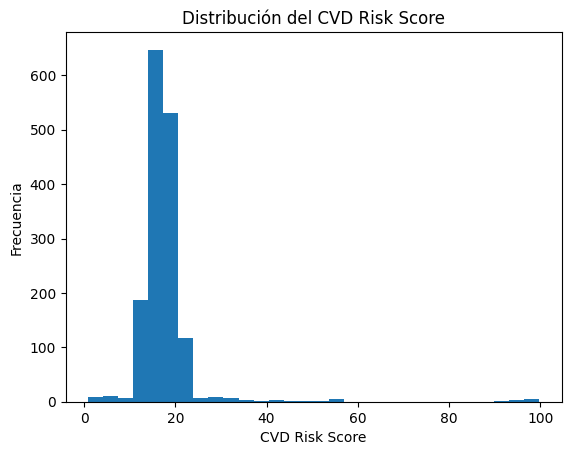

In [1502]:
plt.hist(data_copy["CVD Risk Score"], bins=30)
plt.xlabel("CVD Risk Score")
plt.ylabel("Frecuencia")
plt.title("Distribución del CVD Risk Score")
plt.show()



Es importante destacar que este resultado no implica un error en la implementación del modelo, sino que refleja las limitaciones inherentes al enfoque lineal y a la información disponible. A pesar de ello, el uso de pipelines permitió garantizar un flujo de trabajo correcto, evitando la fuga de información y asegurando que el preprocesamiento se aplicara únicamente a los datos de entrenamiento.

Como posible mejora futura, se podrían explorar modelos no lineales, como árboles de decisión o métodos basados en ensambles, así como la incorporación de nuevas variables clínicas o derivadas, con el fin de capturar relaciones más complejas entre los factores de riesgo y el puntaje cardiovascular.

## 8. Predicciones en test no etiquetado

In [1503]:
print(data_test_copy.columns.tolist())
data_test_copy = seleccionar_registro_unico(data_test_copy)
data_test_copy = limpieza_variables_completitud(data_test_copy)
data_test_copy = limpiar_valores_validez(data_test_copy)

X_final_test = data_test_copy.drop(columns=[TARGET_COL], errors="ignore")
X_final_test = droper(X_final_test)

data_test_copy["CVD Risk Score"] = model_1.predict(X_final_test)

data_test_copy.to_csv("Test.csv", index=False)
data_test_copy.sample(10)

['Patient ID', 'Date of Service', 'Sex', 'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Blood Pressure (mmHg)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Blood Pressure Category', 'Estimated LDL (mg/dL)']


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,ASZW7701,12/02/2023,F,70.0,115.257017,1.754,37.484,95.490,113/119,172.0,...,N,Low,N,175.352,0.545,113.0,119.0,Hypertension Stage 2,77.000,17.648507
89,Xphw8964,"June 19, 2024",F,58.0,64.700000,1.640,24.100,82.100,97/75,151.0,...,N,Low,N,164.000,0.790,97.0,75.0,Normal,81.000,13.677231
33,JFVM7533,"October 28, 2023",F,59.0,76.900000,1.800,23.700,134.089,93/89,294.0,...,N,Moderate,Y,180.000,0.484,93.0,89.0,Hypertension Stage 1,207.000,16.923158
150,mxFg5746,16/11/2024,M,47.0,118.100000,NaN,35.700,93.400,130/87,151.0,...,Y,Low,Y,182.000,0.513,130.0,87.0,Hypertension Stage 1,82.000,18.590461
94,Ymml8812,"January 29, 2021",M,42.0,57.200000,1.610,22.100,98.100,139/61,137.0,...,Y,Low,N,161.000,0.609,139.0,61.0,Hypertension Stage 1,53.000,15.361436
100,Zkqn1426,"March 13, 2023",F,51.0,104.200000,1.640,38.700,82.900,118/97,134.0,...,N,High,Y,164.000,0.505,118.0,97.0,Hypertension Stage 2,74.000,14.366502
68,TIdh1541,10-17-2023,M,76.0,99.586000,1.898,39.517,107.481,171/80,125.0,...,Y,High,N,189.820,0.566,171.0,80.0,Hypertension Stage 1,50.000,21.919607
32,JDyc4377,1/05/2025,F,46.0,118.583920,1.820,35.800,93.500,120/70,260.0,...,N,High,Y,182.000,0.514,120.0,70.0,Elevated,193.000,12.888486
153,pFcN4153,30-oct-23,F,36.0,52.048980,1.710,17.800,103.400,106/88,215.0,...,N,Low,N,171.000,0.605,106.0,88.0,Hypertension Stage 1,289.119,14.806110
40,LQri5564,18/07/2022,M,45.0,106.900000,1.790,33.400,94.500,98/76,228.0,...,Y,Moderate,N,179.000,0.528,98.0,76.0,Normal,124.000,17.797824


## 9. Uso de herramientas de IA generativa

En este laboratorio, la IA generativa fue utilizada principalmente como un recurso de apoyo complementario, y no como un sustituto del razonamiento propio ni del trabajo técnico realizado por el equipo. Su uso se enfocó en resolver dudas puntuales relacionadas tanto con conceptos médicos generales, necesarios para interpretar adecuadamente las variables del dataset, como con buenas prácticas en el análisis y preprocesamiento de datos.

La IA fue consultada para obtener orientación sobre cómo abordar problemas comunes en la limpieza de datos, como el manejo de valores nulos, la identificación de posibles relaciones entre variables que permitieran reducir la incompletitud de los datos y la validación de la consistencia de ciertas mediciones. Asimismo, se utilizó como apoyo técnico para implementar correctamente algunas transformaciones en Python, particularmente con la librería pandas y el diseño de pipelines en scikit-learn.

Es importante resaltar que, aunque la IA proporcionó sugerencias y explicaciones, todas las decisiones finales —como qué variables eliminar, cuáles conservar, cómo imputar valores faltantes y qué modelos entrenar— fueron tomadas de manera autónoma por el equipo, basándose en el análisis del dataset y en los objetivos del laboratorio. La IA no fue utilizada para generar automáticamente resultados, sino como una herramienta de consulta que facilitó la comprensión del problema y apoyó el proceso de toma de decisiones informadas.

En este sentido, la IA generativa funcionó como un asistente académico, contribuyendo a mejorar la calidad del análisis y la implementación técnica, sin reemplazar el criterio ni la responsabilidad del equipo en el desarrollo del modelo.